In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 66% 17.0M/25.7M [00:00<00:00, 72.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 80.3MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/imdb-dataset-of-50k-movie-reviews.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# gathering infoabout the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
# Checking the count of null values
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [9]:
# Replacing sentiment value column in positive and negative as 0 and 1
from  sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['sentiment']= encoder.fit_transform(df['sentiment'])
df.head()
# this has encoded negative as 0 positive as 1

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
# Preprocessor function
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')

def preprocess_text(text):
    # remove HTML tags
    text = re.sub('<[^>]*>', '', text)
    
    # lowercase all characters
    text = text.lower()
    
    # remove special characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    text_tokens = nltk.word_tokenize(text)
    filtered_text = [word for word in text_tokens if word not in stop_words]
    text = ' '.join(filtered_text)
    
    # perform stemming
    porter = PorterStemmer()
    text_tokens = nltk.word_tokenize(text)
    stemmed_text = [porter.stem(word) for word in text_tokens]
    text = ' '.join(stemmed_text)
    
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
df['review'] = df['review'].apply(preprocess_text)

In [13]:
# Using RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [14]:
# Preprocess the text data
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])
labels = df['sentiment'].values
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=max_len)

Found 70958 unique tokens.


final epoch result without dropout lar and learning rate

Epoch 10/10
313/313 [==============================] - 12s 39ms/step - loss: 0.0279 - accuracy: 0.9924 - val_loss: 0.6185 - val_accuracy: 0.8283
313/313 [==============================] - 2s 7ms/step - loss: 0.6185 - accuracy: 0.8283
Test accuracy: 0.8282999992370605

In [15]:
# Improving the model by using LR and adding dropout layers and adding more hidden layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [16]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()
# adam = Adam(learning_rate = 0.5)
# Compile the model
model.compile('rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 322,681
Trainable params: 322,681
Non-trai

I tried usinf dropout layers in multiple positions and multiple values, here is waht i learnt.

1. Adding DL with 0.2 after all layer decreased the diff bw valid loss and loss but was still not satisfactory
2.  If i increase the vaue till 0.5 diffrence between both lossed is reduced but the val accuracy also reduced
3. I tried usind the DL at last layer ony and gives me optimum result with rduced overfitting and still good accuracy

In [17]:
# trying to increase the accuracy
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(Embedding(max_words, 64))
model.add(SimpleRNN(64))

# using L2 regularization to reduce loss
model.add(Dense(32, activation='relu', kernel_regularizer=l2(.025)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(.025)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()
adam = Adam(learning_rate = 0.3)
# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 650,881
Trainable params: 650,881
Non-tr

IN RNN we face vanishing/exploding gradient problem tosolve that we use LSTM.
When we pass the output of previous NN in next activation function along with input of the second NN the formula is
= Input x w(power(No. or rolls/data points))
w-> wight if feedbck loop from previous node ouput

If the weight is more than 1 the step size becomes too big and will not be able to find the minimum value for loss function/minima. Gradient Explode

If the weight is between 0 and 1 step size is too small to reach minima before using total repetitions.: Gradient Vanished

**Using LSTM instead of RNN**

In [19]:
from tensorflow.keras.layers import LSTM

# Build the LSTM model
model = Sequential()
model.add(Embedding(max_words, 64))
model.add(LSTM(64))

# using L2 regularization to reduce loss
model.add(Dense(32, activation='relu', kernel_regularizer=l2(.025)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(.025)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 675,649
Trainable params: 675,649
Non-tr

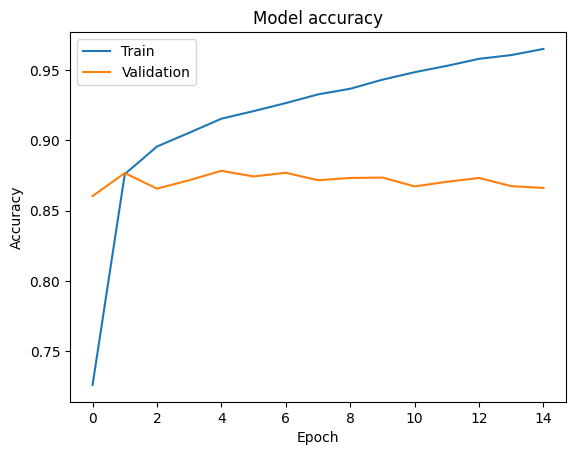

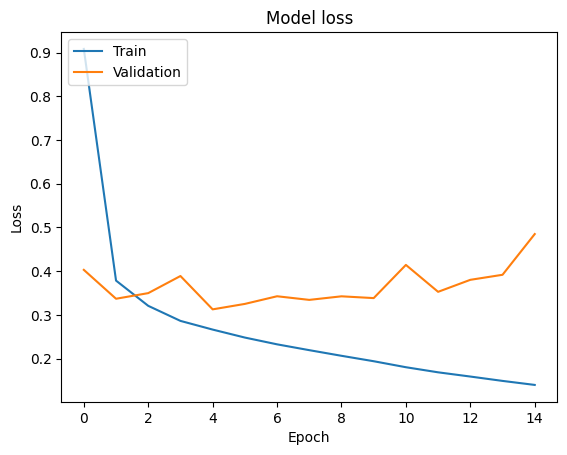

In [21]:
import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

using GRU

In [23]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping

# Build the GRU model
model = Sequential()
model.add(Embedding(max_words, 64))
model.add(GRU(64))

# using L2 regularization to reduce loss
model.add(Dense(32, activation='relu', kernel_regularizer=l2(.025)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(.025)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          640000    
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 667,585
Trainable params: 667,585
Non-tr

No significant improvement seen in both LSTM and GRU even with early stop

**Using word to vec**

In [41]:
import gensim

# Tokenize the text and preprocess it
preprocessed_text = [gensim.utils.simple_preprocess(review) for review in df['review']]

# Build the Word2Vec model
word2vec_model = Word2Vec(preprocessed_text, min_count=2)

# Get the Word2Vec embedding matrix
embedding_matrix = word2vec_model.wv.vectors

# Build the model
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
model.add(LSTM(64))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(.03)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(.03)))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 100)         4200200   
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,245,065
Trainable params: 44,865
Non-t

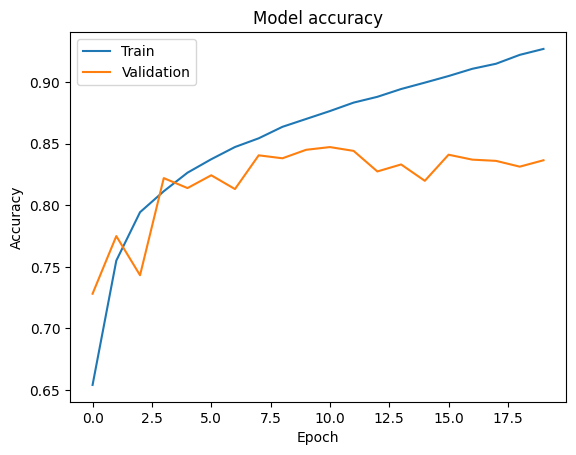

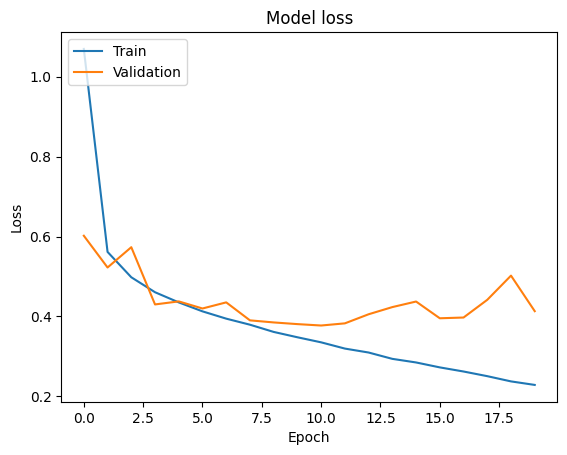

In [42]:
import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()